In [1]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

from common.layers import NoisyLinear
from common.replay_buffer import ReplayBuffer
import gym_Aircraft

from itertools import count
import time
import itertools
import matplotlib
import matplotlib.pyplot as plt

In [2]:
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

In [3]:
env_id = "acav-v0"
env = gym.make(env_id)

/home/jupyter-kunwoopark/.local/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
class RainbowDQN(nn.Module):
    def __init__(self, num_inputs, num_actions, num_atoms, Vmin, Vmax):
        super(RainbowDQN, self).__init__()
        
        self.num_inputs   = num_inputs
        self.num_actions  = num_actions
        self.num_atoms    = num_atoms
        self.Vmin         = Vmin
        self.Vmax         = Vmax
        
        self.linear1 = nn.Linear(num_inputs, 32)
        self.linear2 = nn.Linear(32, 64)
        
        self.noisy_value1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_value2 = NoisyLinear(64, self.num_atoms, use_cuda=USE_CUDA)
        
        self.noisy_advantage1 = NoisyLinear(64, 64, use_cuda=USE_CUDA)
        self.noisy_advantage2 = NoisyLinear(64, self.num_atoms * self.num_actions, use_cuda=USE_CUDA)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        
        value = F.relu(self.noisy_value1(x))
        value = self.noisy_value2(value)
        
        advantage = F.relu(self.noisy_advantage1(x))
        advantage = self.noisy_advantage2(advantage)
        
        value     = value.view(batch_size, 1, self.num_atoms)
        advantage = advantage.view(batch_size, self.num_actions, self.num_atoms)
        
        x = value + advantage - advantage.mean(1, keepdim=True)
        x = F.softmax(x.view(-1, self.num_atoms)).view(-1, self.num_actions, self.num_atoms)
        
        return x
        
    def reset_noise(self):
        self.noisy_value1.reset_noise()
        self.noisy_value2.reset_noise()
        self.noisy_advantage1.reset_noise()
        self.noisy_advantage2.reset_noise()
    
    def act(self, state):
        state = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
        dist = self.forward(state).data.cpu()
        dist = dist * torch.linspace(self.Vmin, self.Vmax, self.num_atoms)
        action = dist.sum(2).max(1)[1].numpy()[0]
        return action

In [5]:
num_atoms = 51
Vmin = -10
Vmax = 10

current_model = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)
target_model  = RainbowDQN(env.observation_space.shape[0], env.action_space.n, num_atoms, Vmin, Vmax)

if USE_CUDA:
    current_model = current_model.cuda()
    target_model  = target_model.cuda()
    
optimizer = optim.Adam(current_model.parameters(), 0.001)

replay_buffer = ReplayBuffer(10000)

In [6]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())
    
update_target(current_model, target_model)

In [7]:
def projection_distribution(next_state, rewards, dones):
    batch_size  = next_state.size(0)
    
    delta_z = float(Vmax - Vmin) / (num_atoms - 1)
    support = torch.linspace(Vmin, Vmax, num_atoms)
    
    next_dist   = target_model(next_state).data.cpu() * support
    next_action = next_dist.sum(2).max(1)[1]
    next_action = next_action.unsqueeze(1).unsqueeze(1).expand(next_dist.size(0), 1, next_dist.size(2))
    next_dist   = next_dist.gather(1, next_action).squeeze(1)
        
    rewards = rewards.unsqueeze(1).expand_as(next_dist)
    dones   = dones.unsqueeze(1).expand_as(next_dist)
    support = support.unsqueeze(0).expand_as(next_dist)
    
    Tz = rewards + (1 - dones) * 0.99 * support
    Tz = Tz.clamp(min=Vmin, max=Vmax)
    b  = (Tz - Vmin) / delta_z
    l  = b.floor().long()
    u  = b.ceil().long()
        
    offset = torch.linspace(0, (batch_size - 1) * num_atoms, batch_size).long()\
                    .unsqueeze(1).expand(batch_size, num_atoms)

    proj_dist = torch.zeros(next_dist.size())    
    proj_dist.view(-1).index_add_(0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1))
    proj_dist.view(-1).index_add_(0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1))
        
    return proj_dist

In [8]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size) 

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = torch.FloatTensor(reward)
    done       = torch.FloatTensor(np.float32(done))

    proj_dist = projection_distribution(next_state, reward, done)
    
    dist = current_model(state)
    action = action.unsqueeze(1).unsqueeze(1).expand(batch_size, 1, num_atoms)
    dist = dist.gather(1, action).squeeze(1)
    dist.data.clamp_(0.01, 0.99)
    loss = -(Variable(proj_dist) * dist.log()).sum(1)
    loss  = loss.mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    current_model.reset_noise()
    target_model.reset_noise()
    
    return loss

In [9]:
num_episodes = 1000
batch_size = 32
gamma=0.99
TARGET_UPDATE=10

losses = []
total_res=[]
reward_list=[]
for i_episode in range(num_episodes):
    total_reward=0
    
    # 환경과 상태 초기화
    res_list=np.zeros(11)
    state = env.reset()

    for t in count():
        # 행동 선택과 수행
        
        action = current_model.act(state)
        
        next_state, reward, done, res = env.step(action)
        
        # 메모리에 변이 저장
        replay_buffer.push(state, action, reward, next_state, done)
        

        # 새로운 상태 관찰
        if not done:
            next_state = next_state
        else:
            next_state = None

        

        # 다음 상태로 이동
        state = next_state

     
        # Data save
        
        cmd_list,r_list,elev_list,azim_list,Pm_list,Pt_list,h_list=res
        Pm_list=Pm_list.tolist()
        Pt_list=Pt_list.tolist()
        merged_data=itertools.chain([cmd_list],[r_list],[elev_list],[azim_list],Pm_list,Pt_list,[h_list])
        merged_data=np.array(list(merged_data))
        res_list=np.vstack([res_list,merged_data])
        
        total_reward+=reward
        
        if done:
            res_list=np.delete(res_list,0,0)
            
            total_res.append(res_list)
            reward_list.append(total_reward)
            
            now = time.localtime()
            print ("%04d/%02d/%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec))
            print("episode : {} | final step : {} | total reward : {}".format(i_episode, t, total_reward))
            break
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(batch_size)
            losses.append(loss.item())
            
        
    #목표 네트워크 업데이트, 모든 웨이트와 바이어스 복사
    if i_episode % TARGET_UPDATE == 0:
        update_target(current_model, target_model)

print('Complete')
env.close()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


2020/10/06 11:24:33
episode : 0 | final step : 100 | total reward : 11.824299022505386
2020/10/06 11:24:34
episode : 1 | final step : 94 | total reward : -14.706097389354468
2020/10/06 11:24:35
episode : 2 | final step : 99 | total reward : -2.6988114762384043
2020/10/06 11:24:36
episode : 3 | final step : 98 | total reward : -2.03208331253893
2020/10/06 11:24:38
episode : 4 | final step : 97 | total reward : -4.2191783175913
2020/10/06 11:24:39
episode : 5 | final step : 99 | total reward : -2.6709450099338454
2020/10/06 11:24:40
episode : 6 | final step : 98 | total reward : -2.6151495218525724
2020/10/06 11:24:41
episode : 7 | final step : 99 | total reward : -2.1864331499533733
2020/10/06 11:24:43
episode : 8 | final step : 100 | total reward : -3.102243280692747
2020/10/06 11:24:44
episode : 9 | final step : 100 | total reward : -3.0055588551162913
2020/10/06 11:24:45
episode : 10 | final step : 100 | total reward : -2.987972869234639
2020/10/06 11:24:46
episode : 11 | final step 

2020/10/06 11:26:20
episode : 94 | final step : 99 | total reward : -2.05576877559011
2020/10/06 11:26:21
episode : 95 | final step : 100 | total reward : -2.794941739561466
2020/10/06 11:26:22
episode : 96 | final step : 99 | total reward : -12.008210617890427
2020/10/06 11:26:23
episode : 97 | final step : 98 | total reward : -3.1929444668825084
2020/10/06 11:26:24
episode : 98 | final step : 97 | total reward : -10.82630706558578
2020/10/06 11:26:25
episode : 99 | final step : 98 | total reward : -3.5212671186879447
2020/10/06 11:26:27
episode : 100 | final step : 100 | total reward : -2.773101624831156
2020/10/06 11:26:28
episode : 101 | final step : 98 | total reward : -3.0340018258657864
2020/10/06 11:26:29
episode : 102 | final step : 98 | total reward : -7.684056082746366
2020/10/06 11:26:30
episode : 103 | final step : 99 | total reward : -4.967155007240791
2020/10/06 11:26:31
episode : 104 | final step : 98 | total reward : -5.307682516710869
2020/10/06 11:26:32
episode : 105

2020/10/06 11:28:06
episode : 187 | final step : 99 | total reward : -3.3827781110591673
2020/10/06 11:28:07
episode : 188 | final step : 97 | total reward : -7.293480447230635
2020/10/06 11:28:08
episode : 189 | final step : 98 | total reward : -6.593639016207618
2020/10/06 11:28:09
episode : 190 | final step : 100 | total reward : -4.000736372196528
2020/10/06 11:28:10
episode : 191 | final step : 94 | total reward : -11.924553827962768
2020/10/06 11:28:12
episode : 192 | final step : 98 | total reward : -2.716217835325125
2020/10/06 11:28:13
episode : 193 | final step : 100 | total reward : -2.9568236210120062
2020/10/06 11:28:14
episode : 194 | final step : 91 | total reward : -21.511034489259842
2020/10/06 11:28:15
episode : 195 | final step : 100 | total reward : -3.118969448969679
2020/10/06 11:28:16
episode : 196 | final step : 100 | total reward : -2.86254460797349
2020/10/06 11:28:17
episode : 197 | final step : 96 | total reward : -13.93020904816484
2020/10/06 11:28:19
episo

2020/10/06 11:29:53
episode : 280 | final step : 93 | total reward : -15.560290361488228
2020/10/06 11:29:54
episode : 281 | final step : 95 | total reward : -9.061522569505286
2020/10/06 11:29:56
episode : 282 | final step : 100 | total reward : -3.1075228628852187
2020/10/06 11:29:57
episode : 283 | final step : 95 | total reward : -11.854274760372206
2020/10/06 11:29:58
episode : 284 | final step : 100 | total reward : -2.8485167070658832
2020/10/06 11:29:59
episode : 285 | final step : 100 | total reward : -2.8389003194031943
2020/10/06 11:30:00
episode : 286 | final step : 99 | total reward : -2.140099632111969
2020/10/06 11:30:01
episode : 287 | final step : 91 | total reward : -25.88042041556838
2020/10/06 11:30:03
episode : 288 | final step : 99 | total reward : -2.535970769250042
2020/10/06 11:30:04
episode : 289 | final step : 99 | total reward : -2.1246600612582256
2020/10/06 11:30:05
episode : 290 | final step : 99 | total reward : -2.1589853948377993
2020/10/06 11:30:06
ep

2020/10/06 11:31:39
episode : 373 | final step : 100 | total reward : -2.267263190701769
2020/10/06 11:31:40
episode : 374 | final step : 99 | total reward : -2.152408266752019
2020/10/06 11:31:41
episode : 375 | final step : 99 | total reward : -4.989829975250686
2020/10/06 11:31:42
episode : 376 | final step : 100 | total reward : -3.69542143337344
2020/10/06 11:31:43
episode : 377 | final step : 97 | total reward : -6.882227480638704
2020/10/06 11:31:44
episode : 378 | final step : 100 | total reward : -12.41232726524612
2020/10/06 11:31:45
episode : 379 | final step : 99 | total reward : -3.320820761820201
2020/10/06 11:31:46
episode : 380 | final step : 100 | total reward : -3.0008665086608914
2020/10/06 11:31:47
episode : 381 | final step : 96 | total reward : -8.072493931538233
2020/10/06 11:31:48
episode : 382 | final step : 99 | total reward : -6.755772552299078
2020/10/06 11:31:49
episode : 383 | final step : 97 | total reward : -5.288710687810251
2020/10/06 11:31:50
episode 

2020/10/06 11:33:17
episode : 466 | final step : 91 | total reward : -19.43119785645915
2020/10/06 11:33:18
episode : 467 | final step : 100 | total reward : -5.630288816182869
2020/10/06 11:33:20
episode : 468 | final step : 98 | total reward : -5.241427483310673
2020/10/06 11:33:21
episode : 469 | final step : 99 | total reward : -4.20746196566688
2020/10/06 11:33:22
episode : 470 | final step : 94 | total reward : -11.804908727332574
2020/10/06 11:33:23
episode : 471 | final step : 97 | total reward : -4.256464985542294
2020/10/06 11:33:24
episode : 472 | final step : 98 | total reward : -3.158952026680595
2020/10/06 11:33:25
episode : 473 | final step : 100 | total reward : -3.078774171127236
2020/10/06 11:33:26
episode : 474 | final step : 99 | total reward : -3.6083022877638626
2020/10/06 11:33:28
episode : 475 | final step : 100 | total reward : -4.362351445307624
2020/10/06 11:33:29
episode : 476 | final step : 99 | total reward : -2.876001162831713
2020/10/06 11:33:30
episode 

2020/10/06 11:35:01
episode : 559 | final step : 96 | total reward : -18.424877654588954
2020/10/06 11:35:03
episode : 560 | final step : 97 | total reward : -5.381129854966673
2020/10/06 11:35:04
episode : 561 | final step : 99 | total reward : -9.17160849119827
2020/10/06 11:35:05
episode : 562 | final step : 100 | total reward : -5.315056054787647
2020/10/06 11:35:06
episode : 563 | final step : 100 | total reward : -4.70552984064372
2020/10/06 11:35:07
episode : 564 | final step : 100 | total reward : -2.801237719974907
2020/10/06 11:35:09
episode : 565 | final step : 100 | total reward : -8.529153732896432
2020/10/06 11:35:10
episode : 566 | final step : 98 | total reward : -3.033350549487821
2020/10/06 11:35:11
episode : 567 | final step : 100 | total reward : -3.8342456705711214
2020/10/06 11:35:13
episode : 568 | final step : 97 | total reward : -4.097373566154133
2020/10/06 11:35:14
episode : 569 | final step : 100 | total reward : -2.773708784670376
2020/10/06 11:35:15
episod

2020/10/06 11:36:41
episode : 652 | final step : 99 | total reward : -4.510772559941103
2020/10/06 11:36:42
episode : 653 | final step : 96 | total reward : -8.355541540973562
2020/10/06 11:36:43
episode : 654 | final step : 100 | total reward : -2.8480643541889634
2020/10/06 11:36:44
episode : 655 | final step : 99 | total reward : -5.32973693116827
2020/10/06 11:36:45
episode : 656 | final step : 100 | total reward : -9.664333078710513
2020/10/06 11:36:46
episode : 657 | final step : 100 | total reward : -14.077229463602421
2020/10/06 11:36:48
episode : 658 | final step : 98 | total reward : -7.590681814940012
2020/10/06 11:36:48
episode : 659 | final step : 100 | total reward : -3.1003151646623053
2020/10/06 11:36:49
episode : 660 | final step : 100 | total reward : -3.702010625212637
2020/10/06 11:36:50
episode : 661 | final step : 97 | total reward : -5.2472559119066915
2020/10/06 11:36:51
episode : 662 | final step : 98 | total reward : -3.6820949622328527
2020/10/06 11:36:52
epi

2020/10/06 11:38:16
episode : 745 | final step : 100 | total reward : -3.9692443217873006
2020/10/06 11:38:16
episode : 746 | final step : 96 | total reward : -6.2317470655655285
2020/10/06 11:38:17
episode : 747 | final step : 97 | total reward : -5.902917205634495
2020/10/06 11:38:18
episode : 748 | final step : 96 | total reward : -16.405101700916447
2020/10/06 11:38:19
episode : 749 | final step : 100 | total reward : -4.38303600958227
2020/10/06 11:38:20
episode : 750 | final step : 98 | total reward : -2.495125344090013
2020/10/06 11:38:21
episode : 751 | final step : 91 | total reward : -22.3557496469966
2020/10/06 11:38:22
episode : 752 | final step : 100 | total reward : -2.778135624495988
2020/10/06 11:38:23
episode : 753 | final step : 91 | total reward : -19.218455200703517
2020/10/06 11:38:24
episode : 754 | final step : 99 | total reward : -11.239332286001698
2020/10/06 11:38:25
episode : 755 | final step : 94 | total reward : -18.45543850918436
2020/10/06 11:38:25
episod

2020/10/06 11:39:35
episode : 838 | final step : 96 | total reward : -16.668398740072192
2020/10/06 11:39:36
episode : 839 | final step : 98 | total reward : -8.374211761714378
2020/10/06 11:39:37
episode : 840 | final step : 100 | total reward : -2.8280951721225023
2020/10/06 11:39:38
episode : 841 | final step : 100 | total reward : -4.147390525693126
2020/10/06 11:39:38
episode : 842 | final step : 100 | total reward : -3.335438074622658
2020/10/06 11:39:39
episode : 843 | final step : 100 | total reward : -2.8039621966163253
2020/10/06 11:39:40
episode : 844 | final step : 97 | total reward : -5.0376852442049085
2020/10/06 11:39:41
episode : 845 | final step : 99 | total reward : -7.43970042805428
2020/10/06 11:39:42
episode : 846 | final step : 97 | total reward : -6.3764415017689515
2020/10/06 11:39:43
episode : 847 | final step : 97 | total reward : -6.665785611306632
2020/10/06 11:39:43
episode : 848 | final step : 100 | total reward : -2.818400348541303
2020/10/06 11:39:44
epi

2020/10/06 11:41:02
episode : 931 | final step : 99 | total reward : -2.657655478644287
2020/10/06 11:41:03
episode : 932 | final step : 98 | total reward : -3.3834696892506884
2020/10/06 11:41:04
episode : 933 | final step : 100 | total reward : -11.394732676692513
2020/10/06 11:41:06
episode : 934 | final step : 91 | total reward : -19.39218861942824
2020/10/06 11:41:07
episode : 935 | final step : 98 | total reward : -9.874038088532345
2020/10/06 11:41:08
episode : 936 | final step : 97 | total reward : -7.329514943414964
2020/10/06 11:41:09
episode : 937 | final step : 95 | total reward : -12.119073917699424
2020/10/06 11:41:11
episode : 938 | final step : 95 | total reward : -12.665875885955302
2020/10/06 11:41:12
episode : 939 | final step : 100 | total reward : -2.93045432041491
2020/10/06 11:41:13
episode : 940 | final step : 100 | total reward : -2.94431233581642
2020/10/06 11:41:14
episode : 941 | final step : 100 | total reward : -2.8692414403758875
2020/10/06 11:41:15
episo

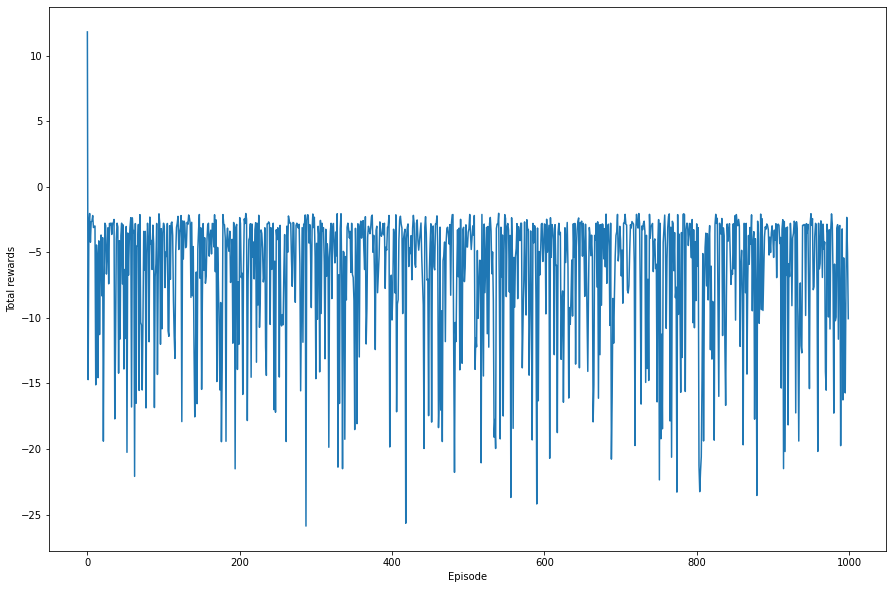

In [10]:
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(reward_list)

In [11]:
def moving_average(data,n):
    len_data=len(data)-n
    res_data=np.zeros(len_data)

    for i in range(len_data):
        res_data[i]=sum(data[i:i+n])/n
    return res_data

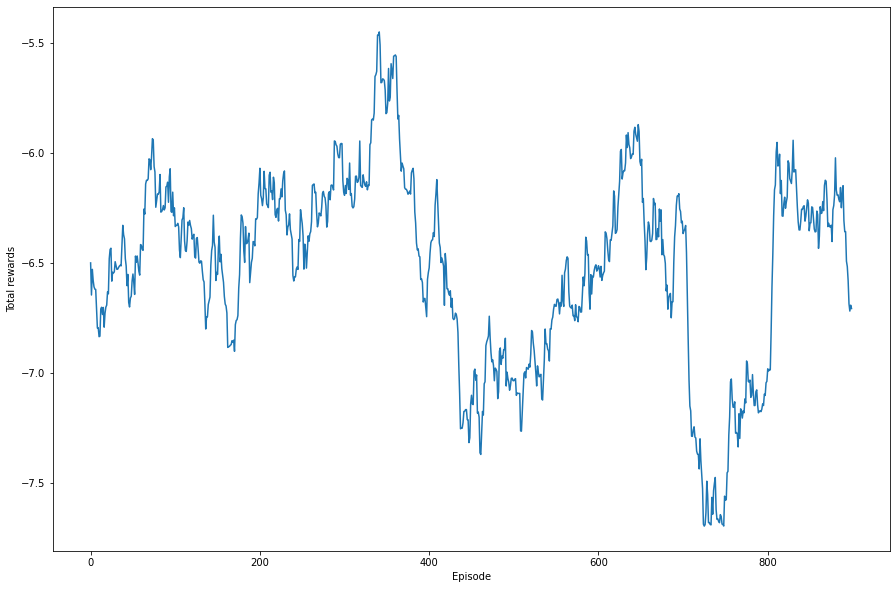

In [12]:
average_number=100
filtered_data=moving_average(reward_list,average_number)
plt.figure(figsize=(15,10))
plt.xlabel("Episode")
plt.ylabel("Total rewards")
plt.plot(filtered_data)

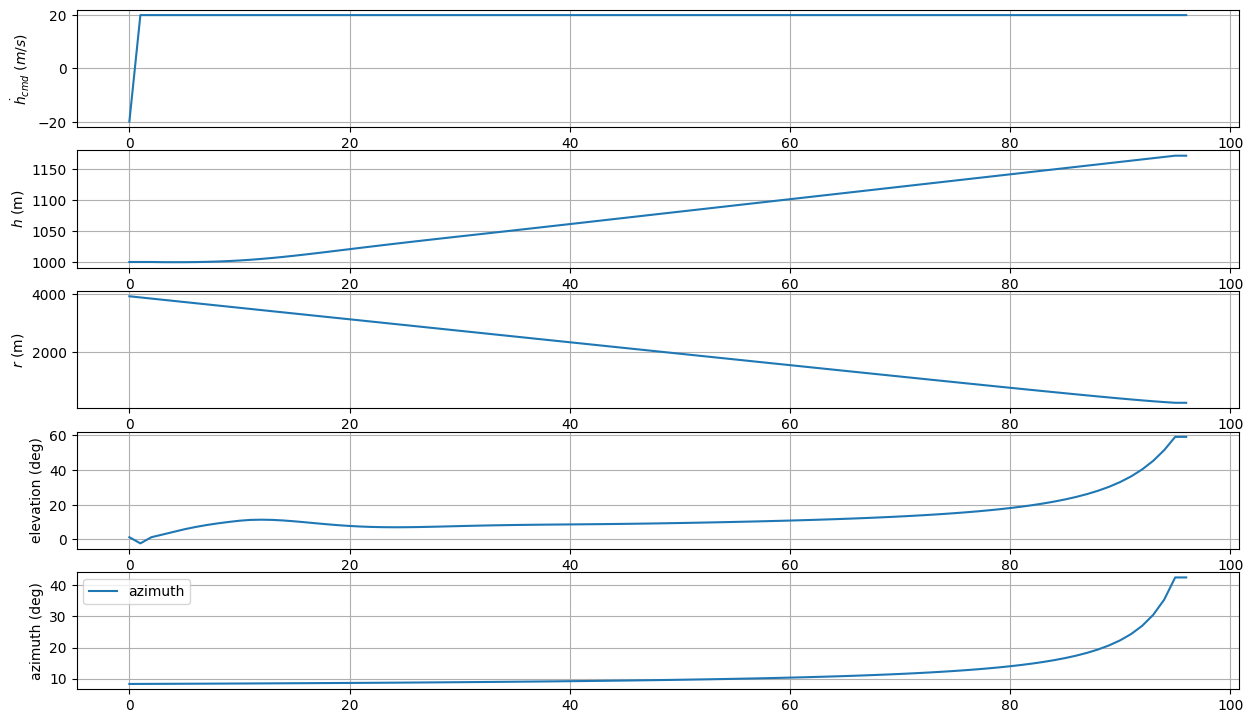

In [13]:
# plots
Deg2Rad = np.pi/180
Rad2Deg = 1/Deg2Rad

plt_res=total_res[999]


plt.figure(figsize=(15,9), dpi=100)

plt.subplot(511)
plt.plot(plt_res[:,0], label=r'$\dot{h}_{cmd}$')
plt.ylabel(r'$\dot{h}_{cmd}$ ($m/s$)'), plt.grid()

plt.subplot(512)
plt.plot(plt_res[:,10],label=r'$\{h}$')
plt.ylabel(r'$h$ (m)'), plt.grid()

plt.subplot(513)
plt.plot(plt_res[:,1],label=r'$\{r}$')
plt.ylabel(r'$r$ (m)'), plt.grid()

plt.subplot(514)
plt.plot(plt_res[:,2]*Rad2Deg, label='elevation')
plt.ylabel('elevation (deg)'), plt.grid()

plt.subplot(515)
plt.plot(plt_res[:,3]*Rad2Deg, label='azimuth')
plt.ylabel('azimuth (deg)'), plt.grid()

plt.legend()
plt.show()

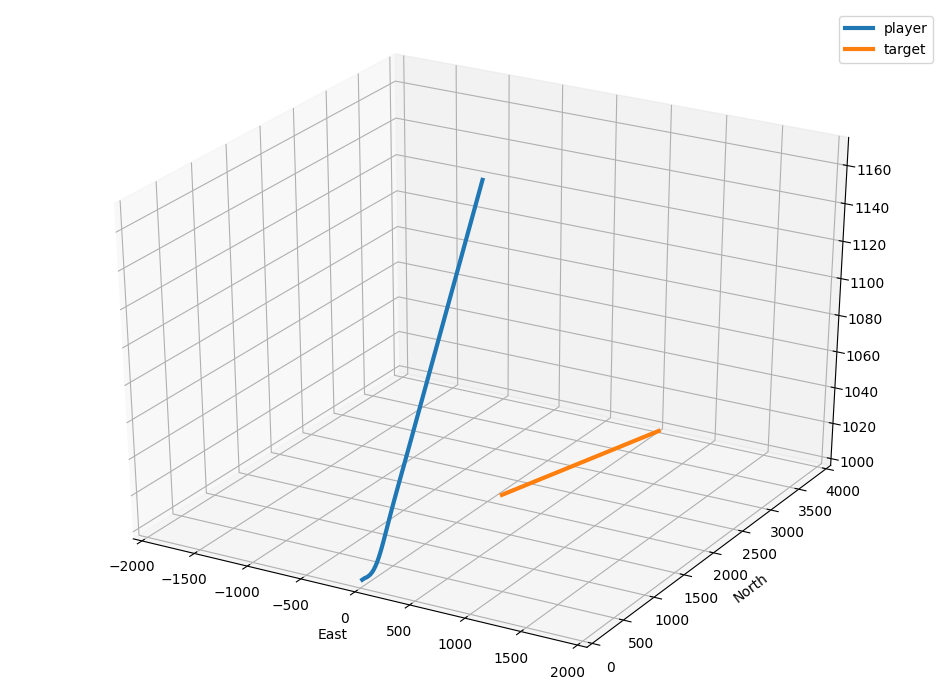

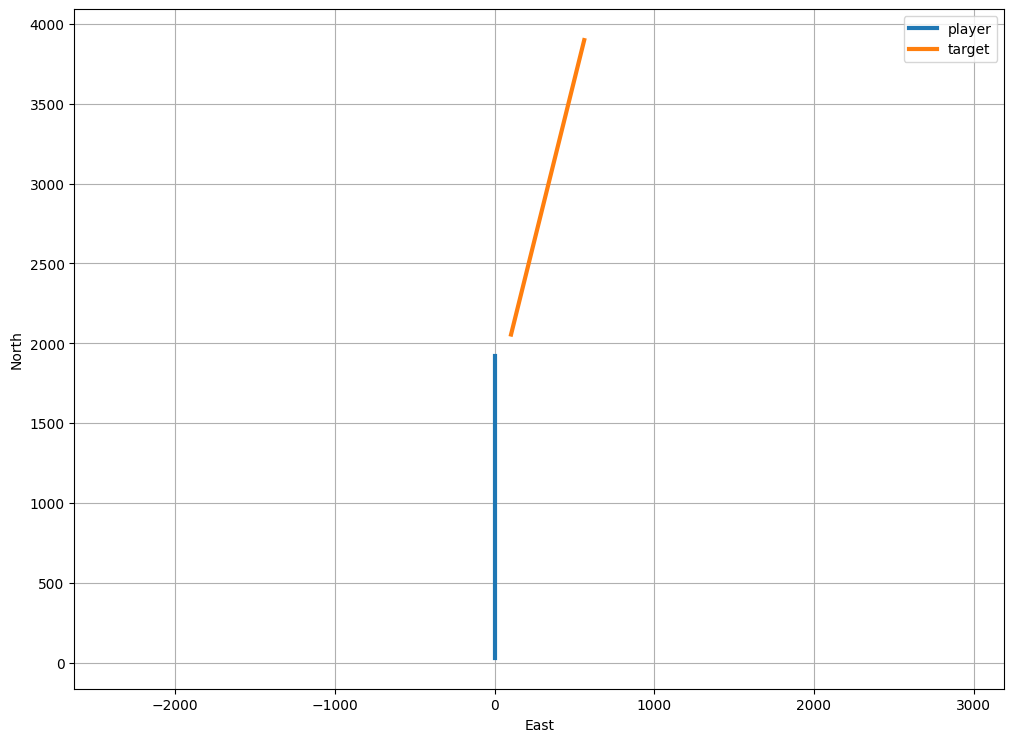

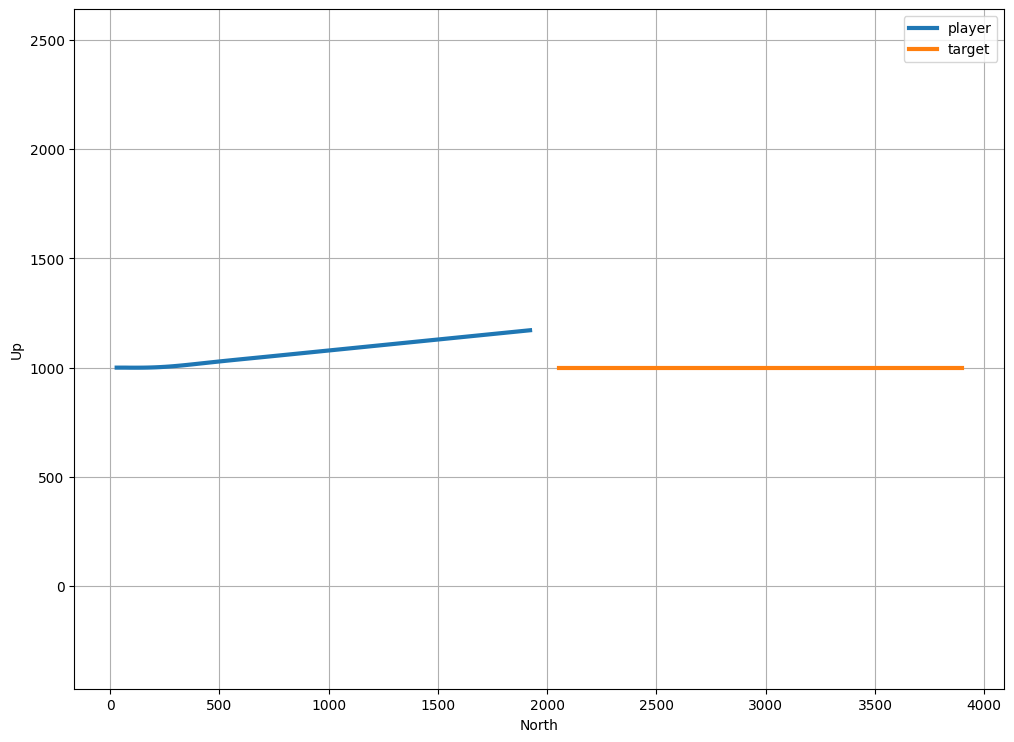

In [14]:
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(12,9), dpi=100)
plt.gca(projection='3d')
plt.plot(plt_res[:,5], plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.xlim(-2000,2000)
plt.ylim(0,4000)
plt.legend()
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,5], plt_res[:,4], label='player', linewidth=3)
plt.plot(plt_res[:,8], plt_res[:,7], label='target', linewidth=3)
plt.xlabel('East')
plt.ylabel('North')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

plt.figure(figsize=(12,9), dpi=100)
plt.plot(plt_res[:,4], -plt_res[:,6], label='player', linewidth=3)
plt.plot(plt_res[:,7], -plt_res[:,9], label='target', linewidth=3)
plt.xlabel('North')
plt.ylabel('Up')
plt.grid(), plt.legend(), plt.axis('equal')
plt.show()

In [15]:
min(plt_res[:,1])

240.0814360201014